<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Numerical-Model" data-toc-modified-id="Numerical-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical Model</a></span></li><li><span><a href="#LSTM-Model" data-toc-modified-id="LSTM-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSTM Model</a></span></li><li><span><a href="#Merge" data-toc-modified-id="Merge-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Merge</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot</a></span></li></ul></div>

# Merge

How to merge multiple models 

*Note: Merge function has been deprecated since Keras Vers 2.2.0*

- https://github.com/keras-team/keras/issues/7417


In [22]:
import keras 
# from numpy import array
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.merge import Concatenate, Add
print(keras.__version__)

print('done')

2.2.0
done


## Dataset

In [2]:
# define documents
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']

# numerical feature 
feature = [45,332,35,325,36,-34,5,-344,-11,-644]

# define class labels
labels = np.array([1,1,1,1,1,0,0,0,0,0])

print(len(labels))

10


## Numerical Model

In [3]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(feature, labels,
            epochs=5,
            verbose=1
           )
score = model.evaluate(feature, labels, verbose=1)
print('Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10/10 [==============================] - 0s 20ms/step - loss: 3.6234 - acc: 0.5000
Epoch 2/5
10/10 [==============================] - 0s 138us/step - loss: 3.3093 - acc: 0.5000
Epoch 3/5
10/10 [==============================] - 0s 157us/step - loss: 2.9960 - acc: 0.5000
Epoch 4/5
10/10 [==============================] - 0s 122us/step - loss: 2.3566 - acc: 0.5000
Epoch 5/5
10/10 [================

## LSTM Model

In [4]:
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs[:10])

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]


In [5]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]


In [6]:
train_lstm = padded_docs.reshape(-1,4,1)

In [7]:
model2 = Sequential()
model2.add(LSTM(16, input_shape=(4,1), return_sequences=False))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

print(model2.summary())

model2.fit(train_lstm, labels, 
            epochs=5,
            verbose=1)

loss, accuracy = model2.evaluate(train_lstm, labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
10/10 [==============================] - 1s 53ms/step - loss: 0.6824 - acc: 0.5000
Epoch 2/5
10/10 [==============================] - 0s 467us/step - loss: 0.6807 - acc: 0.5000
Epoch 3/5
10/10 [==============================] - 0s 469us/step - loss: 0.6785 - acc: 0.5000
Epoch 4/5
10/10 [==============================] - 0s 522us/step - loss: 0.6764 - acc: 0.5000
Epoch 5/5
10/10 [==============================] - 0s 9ms/step
Accuracy: 50.000000


## Merge

In [20]:
conc = Concatenate(axis=1)([model.output, model2.output])
merged = BatchNormalization()(conc)
merged = Dense(1, activation='sigmoid')(merged)

big_model = Model(inputs=[model.input,model2.input], outputs=merged)
big_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
big_model.summary()
big_model.fit([feature, train_lstm], labels,epochs =5,verbose=1) 

loss, accuracy = big_model.evaluate([feature,train_lstm], labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           32          dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1_input (InputLayer)       (None, 4, 1)         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

## Plot

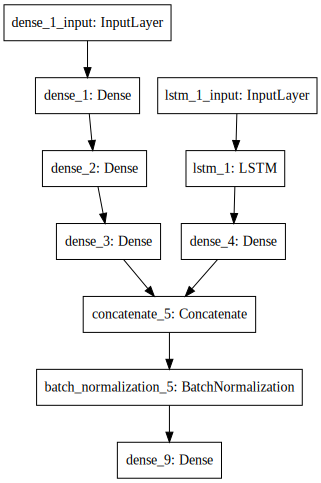

In [21]:
from keras.utils import plot_model
# plot_model(big_model, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(big_model).create(prog='dot', format='svg'))